<a href="https://colab.research.google.com/github/FraPochetti/KagglePlaygrounds/blob/master/BIWI_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone --single-branch --branch keypoints_model --depth 1 https://github.com/FraPochetti/mantisshrimp.git icevision

Cloning into 'icevision'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (406/406), done.
remote: Compressing objects: 100% (373/373), done.
remote: Total 406 (delta 53), reused 209 (delta 20), pack-reused 0
Receiving objects: 100% (406/406), 42.21 MiB | 26.56 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
!pip install -e icevision[all] -q

     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 81kB 6.7MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 194kB 38.2MB/s 
     |████████████████████████████████| 563kB 53.2MB/s 
     |████████████████████████████████| 112kB 44.8MB/s 
     |████████████████████████████████| 1.8MB 52.4MB/s 
     |████████████████████████████████| 36.7MB 88kB/s 
     |████████████████████████████████| 952kB 9.3MB/s 
     |████████████████████████████████| 92kB 13.6MB/s 
     |████████████████████████████████| 256kB 64.4MB/s 
     |████████████████████████████████| 102kB 15.8MB/s 
     |████████████████████████████████| 133kB 59.6MB/s 
     |████████████████████████████████| 102kB 15.1MB/s 
     |████████████████████████████████| 163kB 55.7MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     

In [ ]:
!git clone --single-branch --branch biwi --depth 1 https://github.com/FraPochetti/icedata

Cloning into 'icedata'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (211/211), done.
remote: Total 241 (delta 34), reused 162 (delta 20), pack-reused 0
Receiving objects: 100% (241/241), 41.14 MiB | 35.31 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
!pip install -e icedata

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from icevision.all import *

In [ ]:
data_dir = icedata.biwi.load_data()
parser = icedata.biwi.parser(data_dir)

In [ ]:
train_records, valid_records = parser.parse()

INFO     - Autofixing records | icevision.parsers.parser:parse:124


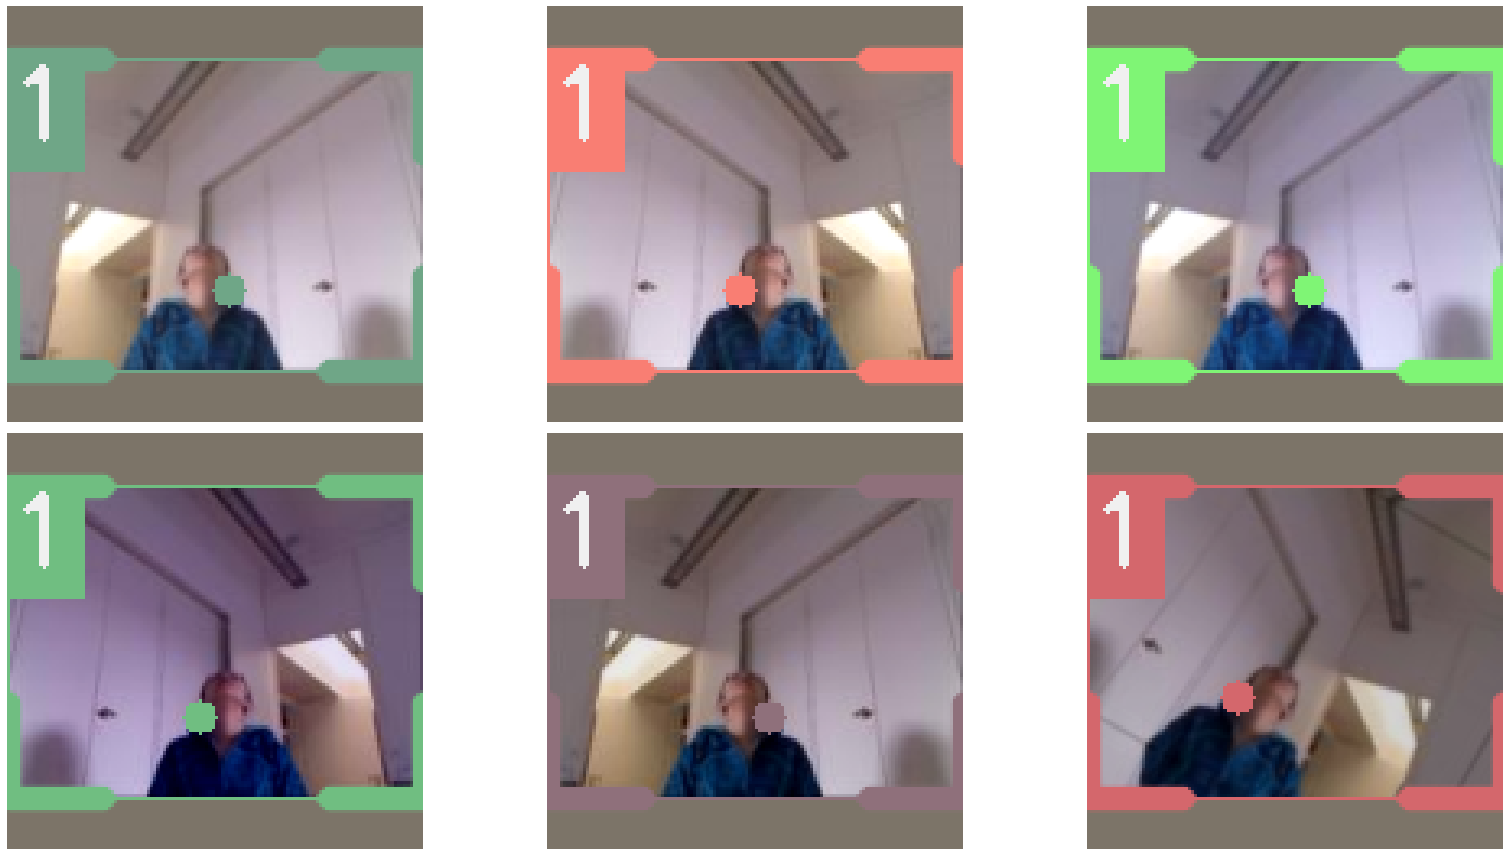

In [ ]:
presize = 256
size = 128

valid_tfms = tfms.A.Adapter([tfms.A.LongestMaxSize(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize, crop_fn=None), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

samples = [train_ds[1] for _ in range(6)]
show_samples(samples, ncols=3)

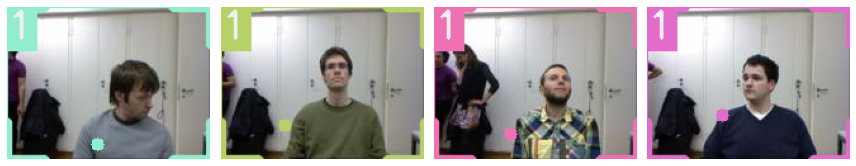

In [ ]:
show_records(valid_records[:4], ncols=4)

In [ ]:
train_dl = keypoint_rcnn.train_dl(train_ds, batch_size=32, num_workers=4, shuffle=True)
valid_dl = keypoint_rcnn.valid_dl(train_ds, batch_size=32, num_workers=4, shuffle=False)

In [ ]:
backbone = backbones.resnet_fpn.resnet50(pretrained=True)
model = keypoint_rcnn.model(backbone=backbone, num_keypoints=1)

In [ ]:
learn = keypoint_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model)

SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=1.737800812406931e-05)

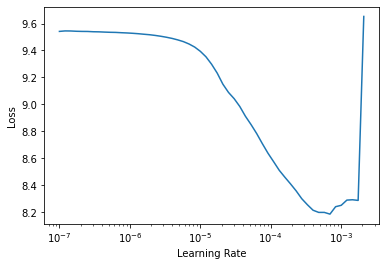

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(20, 1e-4, freeze_epochs=5)

epoch,train_loss,valid_loss,time
0,9.469464,9.322597,00:41
1,9.281044,8.661966,00:40
2,8.886078,7.848914,00:47
3,8.528202,7.382205,00:16
4,8.199897,7.166939,00:16


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: ignored

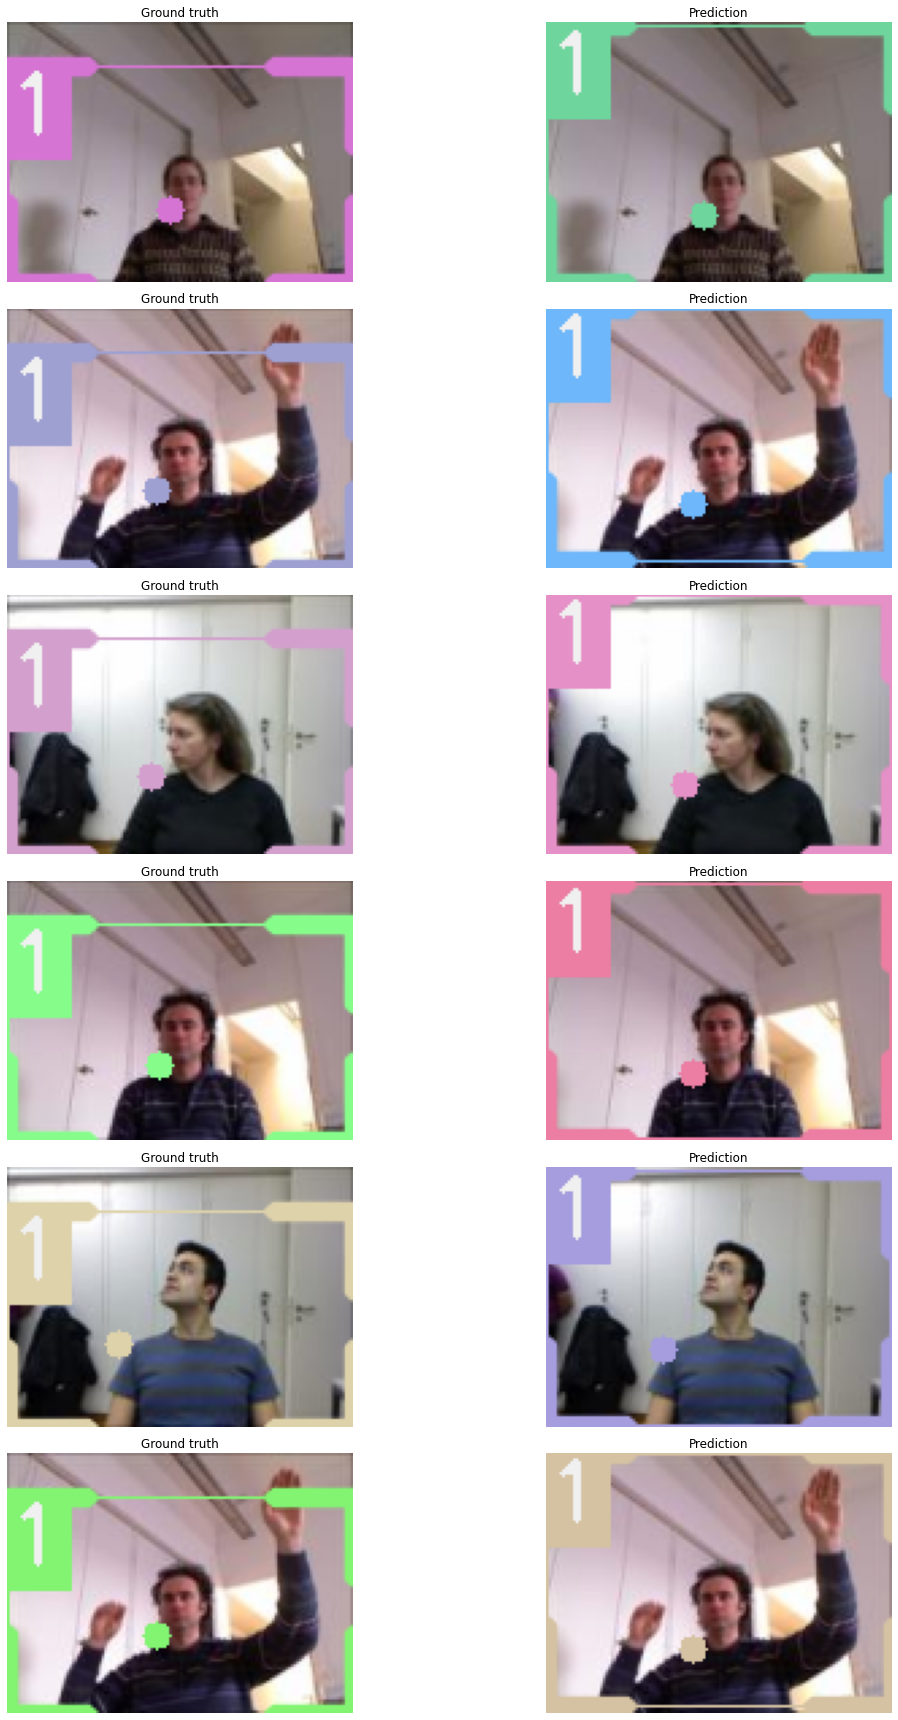

In [ ]:
keypoint_rcnn.show_results(model, valid_ds)

In [ ]:
infer_dl = keypoint_rcnn.infer_dl(valid_ds, batch_size=8)
samples, preds = keypoint_rcnn.predict_dl(model=model, infer_dl=infer_dl)

In [ ]:
preds[1]

{'above_threshold': tensor([True], device='cuda:0'),
 'bboxes': [<BBox (xmin:0.0885162353515625, ymin:0.0, xmax:128.0, ymax:93.47561645507812)>],
 'keypoints': [<KeyPoints (N visible keypoints: 1)>],
 'keypoints_scores': array([[0.5050627]], dtype=float32),
 'labels': array([1]),
 'scores': array([0.9999051], dtype=float32)}

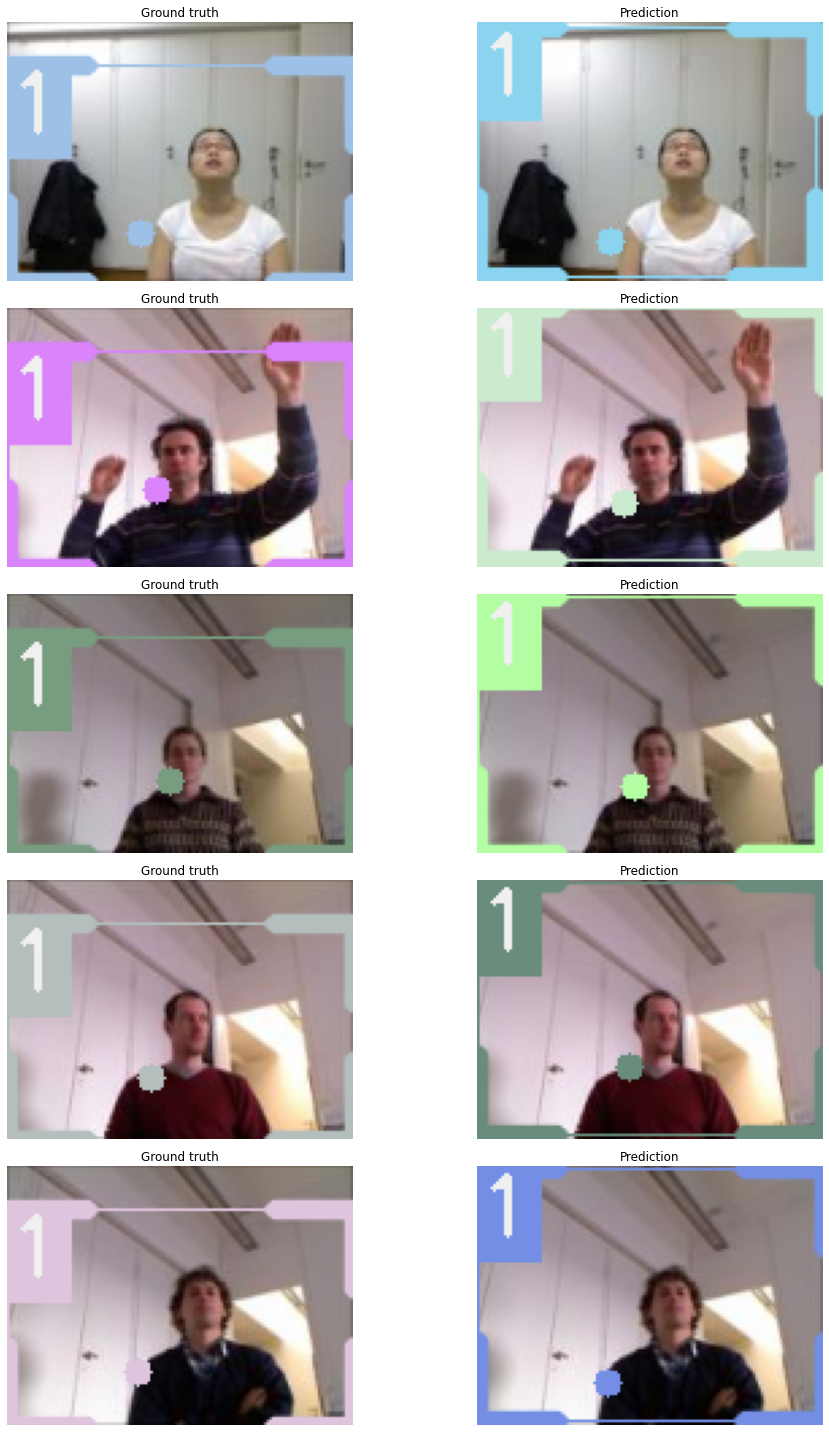

In [ ]:
show_preds(samples=samples[:5], preds=preds[:5], show=True)

In [ ]:
class LightModel(keypoint_rcnn.lightning.ModelAdapter):
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-4)

light_model = LightModel(model)

trainer = pl.Trainer(max_epochs=20, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | KeypointRCNN | 59 M  


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

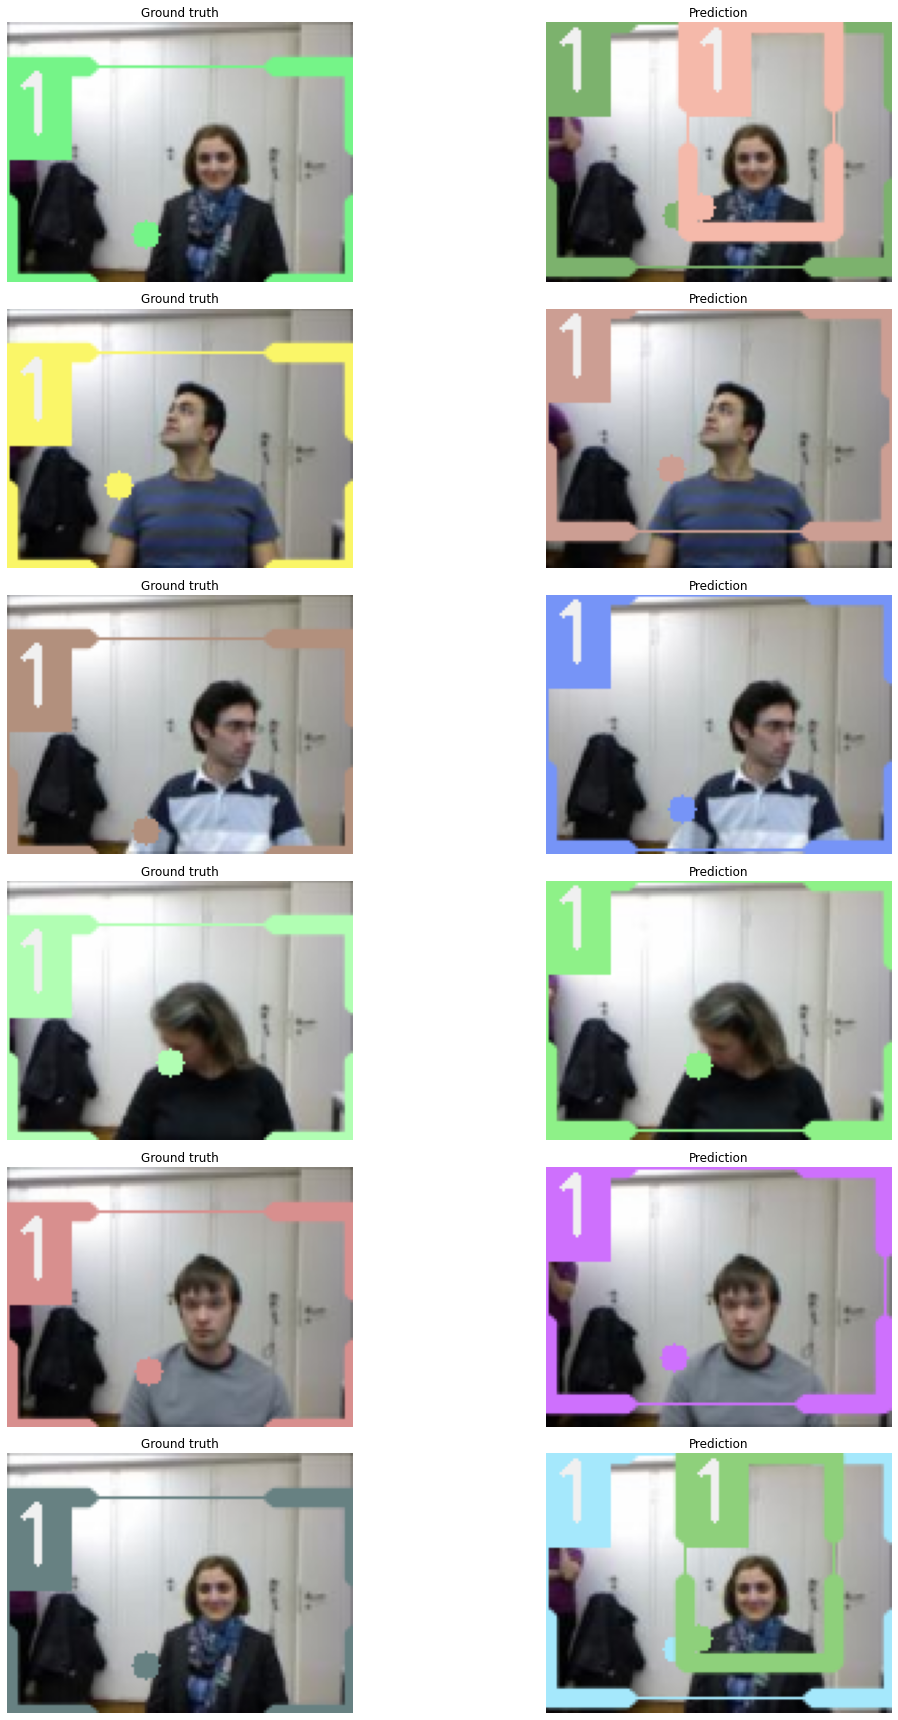

In [ ]:
keypoint_rcnn.show_results(light_model, valid_ds)